In [86]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

def fetch(url):
    import pathlib, requests,os, hashlib, numpy, gzip, tempfile
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode("utf-8")).hexdigest())
    if(os.path.isfile(fp)):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()


#fetch data
X_train = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz")
Y_train = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz")
X_test = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz")
Y_test = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz")

#normalize pixel
def preprocess_mnist(data):
    data = data[16:]   
    images = data.reshape(-1, 28, 28) 
    images = images.astype('float32') / 255.0
    
    return images

X_train_normalized = preprocess_mnist(X_train).reshape(-1,784)
X_test_normalized = preprocess_mnist(X_test).reshape(-1,784)

#one-hot encoding
def one_hot_encoding(data):
    data = data[8:]  # Offset zum Entfernen des Headers bei den Label-Daten
    n_labels = len(data)
    one_hot = np.zeros((n_labels, 10), dtype=np.int8)
    
    one_hot[np.arange(n_labels), data] = 1
    
    return one_hot

# Labels für das Training und Testen in One-Hot-Encoding umwandeln
Y_train_one_hot = one_hot_encoding(Y_train)
Y_test_one_hot = one_hot_encoding(Y_test)

In [124]:
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        self.rng = np.random.default_rng()
        
        # Initialisierung der Gewichte mit der layer_init Funktion
        self.w1 = self.layer_init(input_size, hidden_size)
        self.w2 = self.layer_init(hidden_size, hidden_size)
        self.w3 = self.layer_init(hidden_size, output_size)
        
        self.b1 = np.zeros((1, hidden_size), dtype=np.float32)
        self.b2 = np.zeros((1, hidden_size), dtype=np.float32)
        self.b3 = np.zeros((1, output_size), dtype=np.float32)

 
    def layer_init(self, m, h):
        ret = self.rng.normal(0, np.sqrt(2 / m), size=(m, h))
        return ret.astype(np.float32)


    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    def forward(self, x):
        self.z1 = np.dot(x,self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        output = self.softmax(self.z3)
        return output

    @staticmethod
    def softmax(x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp/np.sum(exp, axis=1, keepdims=True)

    def backward(self, x, y, output):
        m = y.shape[0]
        dz3 = output - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m
        dz2 = np.dot(dz3, self.w3.T) * (self.z2 > 0)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.w2.T) * (self.z1 > 0)
        dW1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Gewichte aktualisieren
        learning_rate = 0.01
        self.w1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.w3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        
    def accuracy(self, prediction, y_train):
        rs = np.argmax(prediction, axis=1)
        y_train_rs = np.argmax(y_train, axis=1)
        return np.mean(rs==y_train_rs)
        
    def train(self, x_train, y_train, epochs):
        self.loss_values = []
        self.accuracy_values = []
        for epoch in (t := trange(epochs)):
            output = self.forward(x_train)
            acc = self.accuracy(output,y_train)
            self.accuracy_values.append(acc)
            loss = self.cross_entropy(output, y_train)
            self.loss_values.append(loss)
            self.backward(x_train, y_train, output)
            # Korrigierte Ausgabeformatierung
            t.set_description("Epoch: %d Loss: %.3f" % (epoch, loss))
            
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(self.loss_values, label="Loss")
            plt.plot(self.accuracy_values, label="Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Loss/Accuracy")
            plt.title(f"Training Loss/Accuracy over Epochs - Epoch {epoch+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Setze die Progress-Bar-Beschreibung
            t.set_description(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
            

        
    def cross_entropy(self, predictions, targets):
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]
        loss = -np.sum(targets * np.log(predictions)) / N
        return loss

    def predict(self, x):
        res = np.argmax(self.forward(x)) 
        return res
        

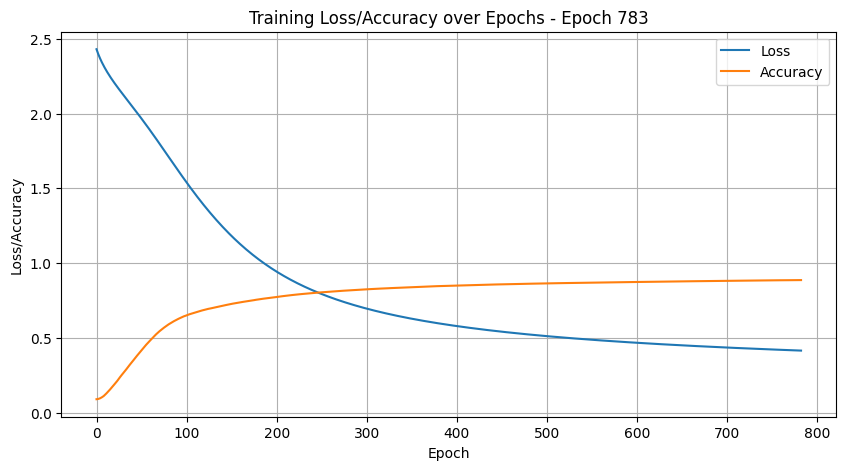

Epoch: 783 Loss: 0.414:  78%|███████████████████████▍      | 783/1000 [01:57<00:33,  6.53it/s]

In [ ]:
nn = Model(784, 128, 10)
nn.train(X_train_normalized, Y_train_one_hot, 1000)

In [118]:
rnd = np.random.randint(10000)
test_x = X_test_normalized[rnd]
test_y = np.argmax(Y_test_one_hot[rnd])
result = nn.predict(test_x)
acc = nn.accuracy(result, test_y)
print("Prediction: %d, Accuracy: %d, Y_test_label: %d" % (result,acc, test_y))

Prediction: 2, Y_test_label: 2
